<a href="https://colab.research.google.com/github/coronarita1991/AIFFEL_RESEARCH_STUDY/blob/main/Ablation_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 프로젝트 루브릭 및 CIFAR-10 datasets 가져오기

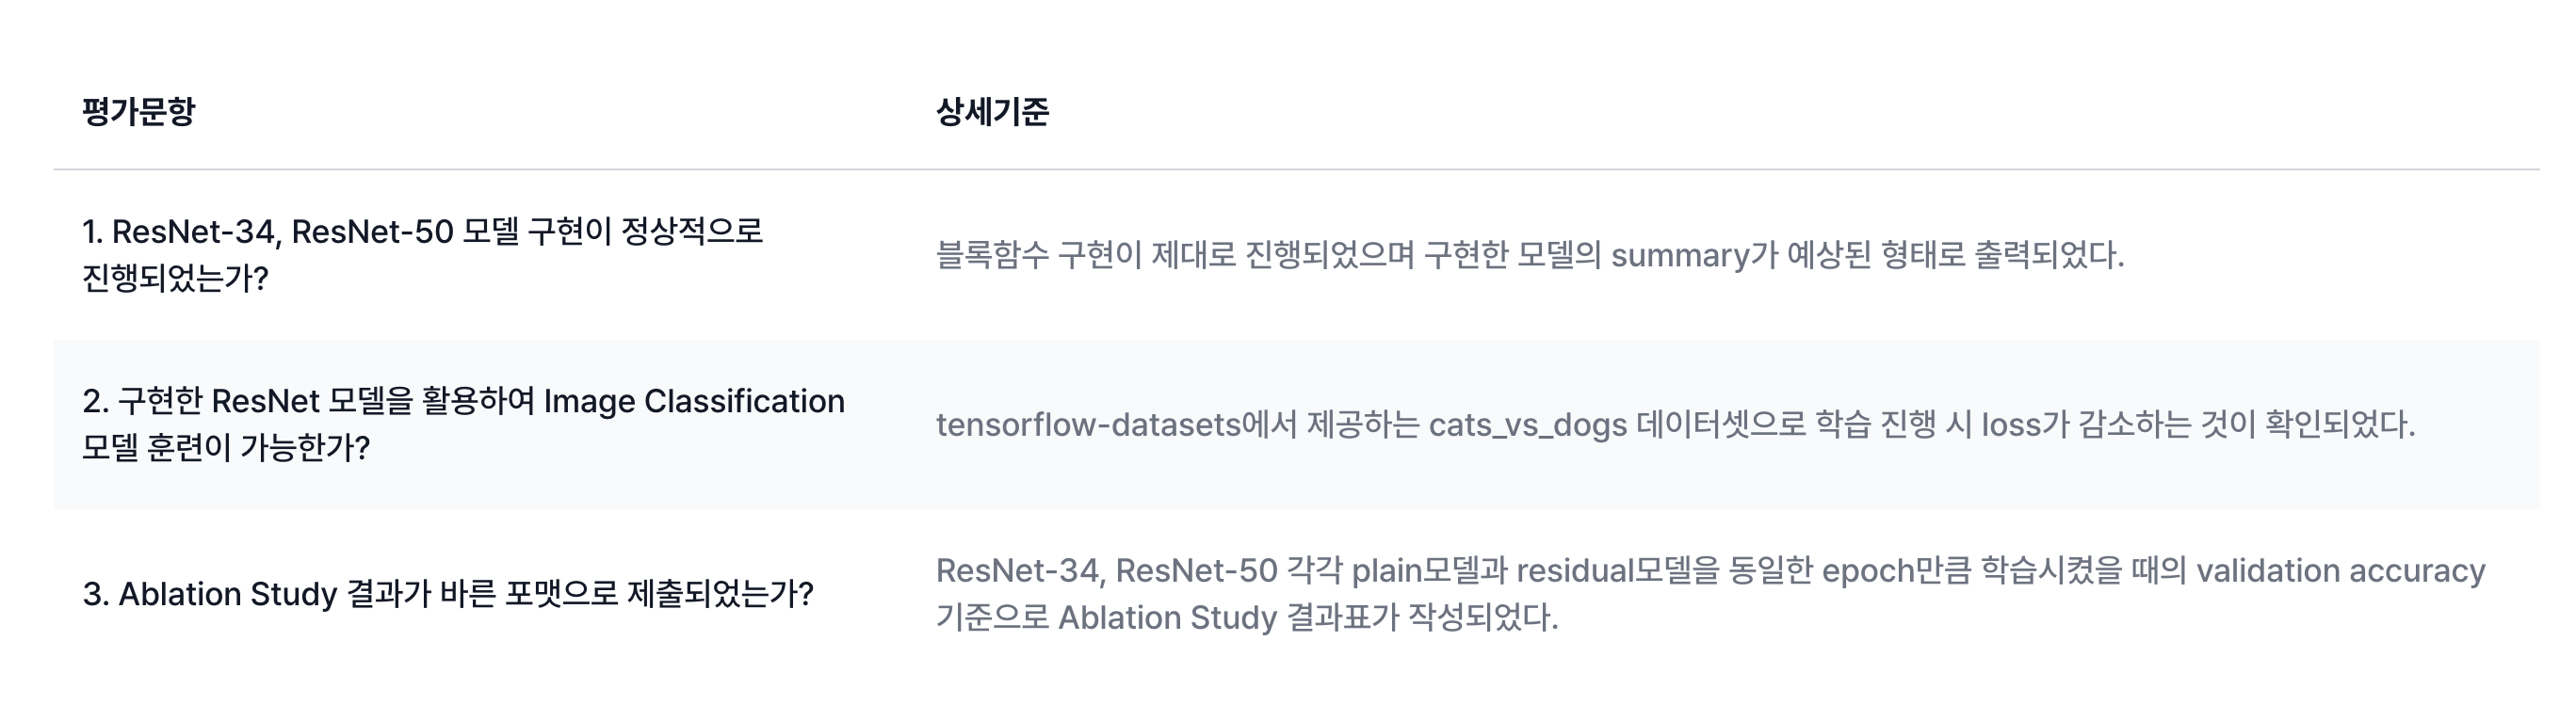

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
print(tf.__version__)
print(np.__version__)

2.15.0
1.25.2


In [2]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[]

In [3]:
import urllib3
urllib3.disable_warnings()

 # 데이터셋 다운로드의 프로그레스 바가 나타나지 않게 합니다.
# tfds.disable_progress_bar()

(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/incomplete.NHZGZB_3.0.2/cifar10-train.tfrecord*...:   0%|         …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/incomplete.NHZGZB_3.0.2/cifar10-test.tfrecord*...:   0%|          …

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [4]:
# Tensorflow dataset에 대한 feature 확인
print(ds_info.features)

FeaturesDict({
    'id': Text(shape=(), dtype=string),
    'image': Image(shape=(32, 32, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
})


In [5]:
# 데이터 수 확인 - numpy가 아니기 때문에, .shape 호출은 불가능
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(50000, shape=(), dtype=int64)
tf.Tensor(10000, shape=(), dtype=int64)


In [6]:
# 정규화 진행
def normalize_and_resize_img(image, label, size):
    """Normalizes images: `uint8` -> `float32`."""

    # Resize
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [size, size])

    # Normalize
    image /= 255.0

    return image, label

In [7]:
print(type(ds_train))
print(type(ds_test))

<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


In [8]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, img_size=32):
    # apply normalize
    ds = ds.map(
        lambda x, y: normalize_and_resize_img(x, y, img_size),
        num_parallel_calls=1
    )
    # make batch
    ds = ds.batch(batch_size)

    if not is_test:
        ds = ds.repeat() # 정확하게 이해하지는 못했음. 아마 매학습마다 반복을 해주는데
        ds = ds.shuffle(200) # shuffle을 두어서 미리 담아둘수 있는 공간을 확보

    ds = ds.prefetch(tf.data.experimental.AUTOTUNE) # 미리 최적 배치들을 준비하게 함

    return ds

In [9]:
ds_info.features['label'].num_classes

10

In [10]:
ds_info.features['label'].names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

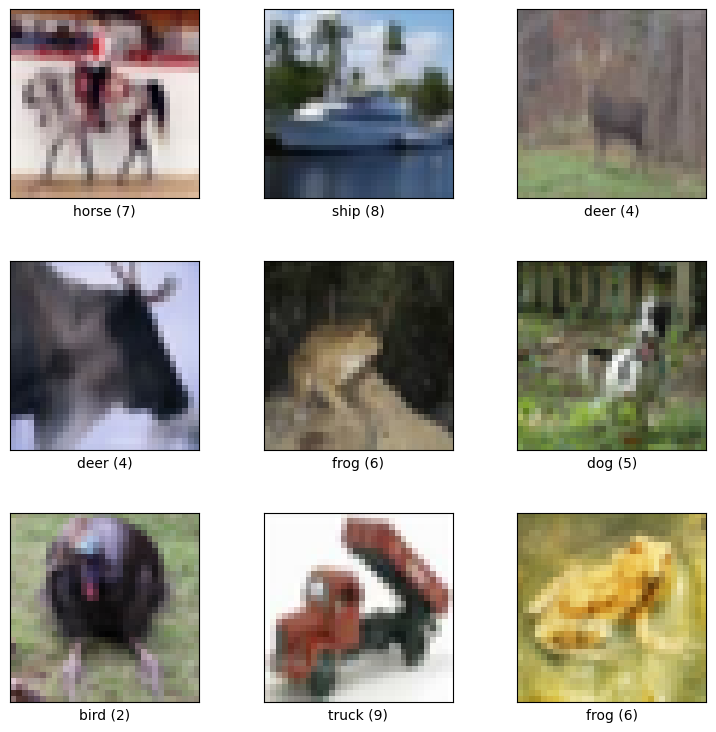

In [11]:
# 데이터 예시 보기
fig = tfds.show_examples(ds_train, ds_info)

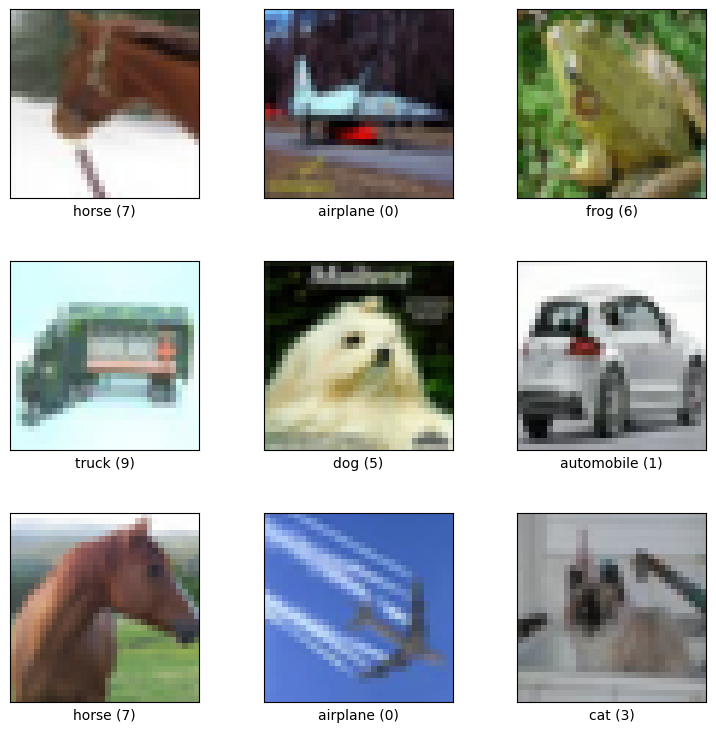

In [12]:
fig = tfds.show_examples(ds_test, ds_info)

# 1) ResNet 기본 블록 구성하기

- 이제 실전으로 돌아와서 ResNet-34와 ResNet-50 네트워크를 직접 만든다고 생각해 봅시다.
- 우선 ResNet-34와 ResNet-50에서 사용되는 블록의 공통점을 찾고 차이점을 찾아봅시다.

    [Deep Residual Learning for Image Recognition(paper)](https://arxiv.org/pdf/1512.03385.pdf)

    [빛과 같은 카이밍허님의 깃헙](https://github.com/KaimingHe/deep-residual-networks)




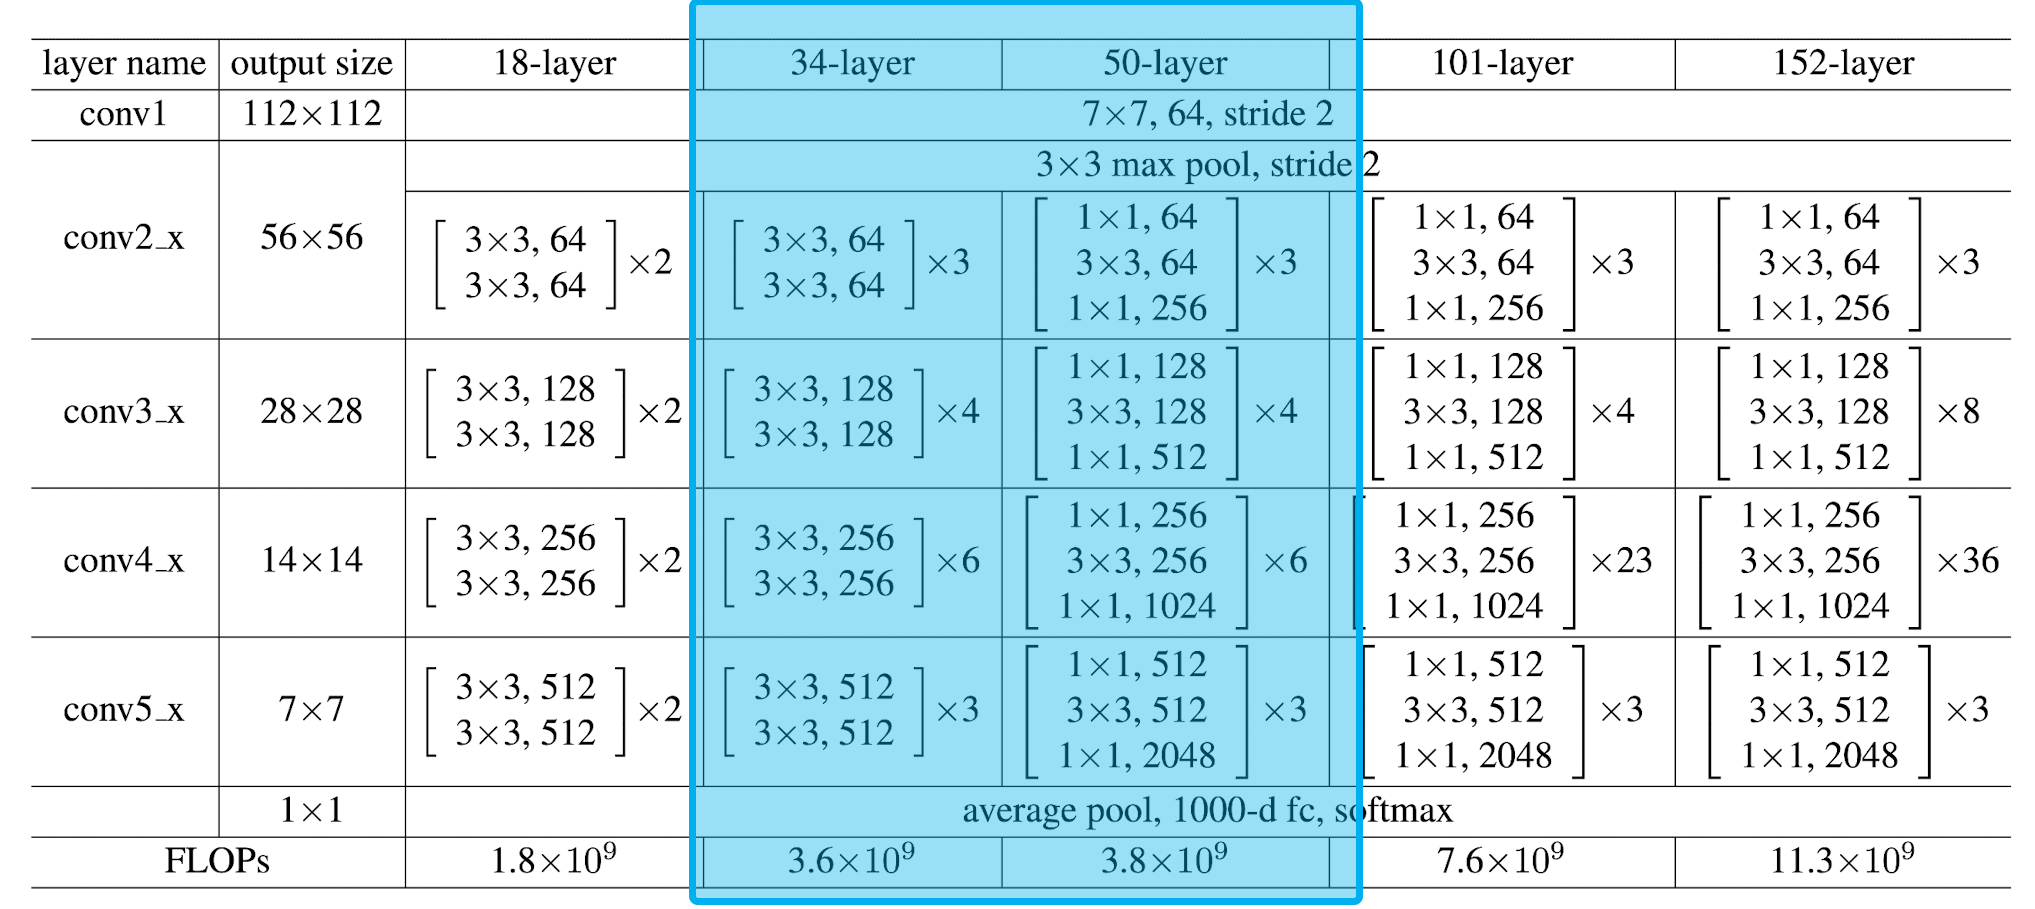

### ***공통점***

- conv_1, 2, 3, 4, 5의 수, 그리고 이후 average pooling, softmax등의 구조가 유사하다.

### ***차이점***
- layer 수가 다른데, 16개의 레이어가 차이가 나며, 단위 모듈에 구성된 부분에 앞, 뒤에 각각 1x1의 convolution이 추가되어 있다.

# 2) ResNet-34, ResNet-50 Complete Model

ResNet 모델 구현 시 Sequential API나 Subclass API를 사용한다면, 그 과정에서 모델 단위로 기존의 코드를 재활용했을 때 model.summary() 호출 시 서브모델 내부의 레이어 구성이 생략되고 서브모델 단위로만 출력될 우려가 있습니다. 모델 구성만을 위해서는 그런 방법도 무방하지만, 가급적 이번 실습에서는 VGG 실습 예시에서처럼 Functional API 를 구성하는 방식을 사용할 것을 권합니다.



## ResNet-34

- VGG와 같이 블록을 만드는 함수를 사용해서 직접 전체 모델을 만들어 봅시다. ResNet-34와 ResNet-50의 차이에 따라 달라지는 구성(configuration)을 함수에 전달해서 같은 생성 함수 build_resnet()를 통해서 ResNet의 여러 가지 버전들을 모두 만들어 낼 수 있도록 해야 합니다.

다음의 코드를 실행하면,

In [21]:
# Func for VGG
def build_vgg_block(input_layer,
                    num_cnn=3,
                    channel=64,
                    block_num=1,
                    ):
    # Input
    x = input_layer

    # Convolution
    for cnn_num in range(num_cnn):
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3, 3),
            activation='relu',
            kernel_initializer='he_normal', #
            padding='same',
            name=f'block{block_num}_conv{cnn_num}'
        )(x)

    # Max Pooling
    x = keras.layers.MaxPooling2D(
        pool_size=(2, 2),
        strides=(2, 2),
        name=f'block{block_num}_pooling'
    )(x)

    return x


진행 중임

In [22]:
# Resnet 생성하는 함수

def build_resnet(input_shape=(32, 32, 3),
              num_cnn_list=[1,3,4,6,3],
              channel_list=[64,64,128,256,512],
              channel_last_list=[64,256,512,1024,2048],
              # num_cnn_list, channel_list config list으로 추정
              num_classes=10,
                is_50=False):
    assert len(num_cnn_list) == len(channel_list) # 모델 생성 전 일치 여부를 체크
    assert len(num_cnn_list) == len(channel_last_list) # 모델 생성 전 일치 여부를 체크

    input_layer = keras.layers.Input(shape=input_shape)
    output = input_layer

    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_vgg_block(
            output,
            num_cnn=num_cnn,
            channel=channel,
            block_num=i
        )

    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc1')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc2')(output)
    output = keras.layers.Dense(num_classes, activation='softmax',
                                name='predictions')(output)

    model = keras.Model(
        inputs=input_layer,
        outputs=output
        )

    return model



In [ ]:
resnet_34 = build_resnet(input_shape=(32, 32, 3), is_50=False)
resnet_34.summary()

## ResNet-50

위에서 만든 함수에 config를 조절해서 ResNet-50을 만들어 봅니다. 구조가 원하는 대로 만들어졌는지 확인하고 이상이 있다면 수정합니다.

In [ ]:
resnet_50 = build_resnet(input_shape=(32, 32, 3), is_50=True)
resnet_50.summary()

ResNet-50은 구현마다 약간씩 다르게 나올 수 있습니다. 왜냐하면 Residual 블록의 Batch Normalization과 ReLU 레이어의 위치가 논문에 명시되지 않았기 때문이죠!

하지만 ResNet을 고안한 4인방은 이에 대해 또 한번 논문을 씁니다. Residual 블록에 대해서 자세하게 씁니다. 이 논문을 읽어보면 오리지널 ResNet-50에 대한 힌트가 약.간. 있을 수도 있습니다~!

[Identity Mappings in Deep Residual Networks](https://arxiv.org/pdf/1603.05027.pdf)


# 3) 일반 네트워크(plain network) 만들기
## 블록 코드 수정하기

우리는 앞에서 ResNet 모델을 구현했습니다. ResNet의 핵심 아이디어는 skip connection과 residual network기 때문에, ResNet의 효과를 보여주기 위해서는 skip connection이 없는 일반 네트워크(plain net)가 필요합니다. 위에서 ResNet 블록을 만들기 위한 함수를 그대로 활용해서 skip connection이 없는 블록을 만들 수 있도록 기능을 추가해 주세요!


## 전체 함수 코드 수정하기

이제 위에서 만든 블록 함수를 토대로 전체 네트워크를 만들 수 있도록 전체 네트워크 코드를 수정합시다. ResNet-50과 ResNet-34, 그리고 같은 레이어를 가지지만 skip connection이 없는 PlainNet-50과 PlainNet-34를 만들 수 있는 함수 build_plainnet()를 만들어 보세요. 이때 입력 이미지의 크기는 (224, 224, 3)으로 해주세요.


# 4) ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34
## Ablation Study

이제 VGG-16, 19 예제와 같이 ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34에 대해서 학습을 진행해 봅니다. 그리고 결과를 비교해 봅시다! ResNet은 많은 레이어와 Pooling을 거치므로 CIFAR-10에서는 오버피팅(overfitting)으로 잘 동작하지 않을 수 있습니다. 레이어가 많고 학습해야 할 변수(parameter)가 많은 데 비해, 데이터 수가 많지 않기 때문이지요. 224x224 픽셀 크기의 데이터셋을 찾아서 실험해 보도록 합시다. 학습은 끝까지 시키기엔 시간이 없으니 확인을 위한 정도의 epoch로 설정해 주세요.

어떤 데이터셋을 사용하셔도 무방하지만, 얼른 떠오르는 것이 없다면 tensorflow-datasets에서 제공하는 cats_vs_dogs 데이터셋을 추천합니다. 아마 이 데이터셋도 다루어 보신 적이 있을 것입니다. Tensorflow에서 제공하는 데이터셋이므로 오늘 VGG 학습에 사용했던 CIFAR-10을 로딩하는 것과 같은 방법으로 활용하실 수 있습니다.

혹시 에러가 발생했나요? 그렇다면 다음의 링크를 읽어보세요

[tensorflow_datasets.load('cats_vs_dogs') not working !](https://github.com/tensorflow/datasets/issues/3918)

어떤 에러가 발생했을까요?

In [19]:
setattr(tfds.image_classification.cats_vs_dogs, '_URL',"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")

ds_train, ds_info = tfds.load(
    'cats_vs_dogs',
    # split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)


In [20]:
ds_info

tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    full_name='cats_vs_dogs/4.0.1',
    description="""
    A large set of images of cats and dogs. There are 1738 corrupted images that are dropped.
    """,
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    data_dir='/root/tensorflow_datasets/cats_vs_dogs/4.0.1',
    file_format=tfrecord,
    download_size=786.67 MiB,
    dataset_size=1.04 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=23262, num_shards=16>,
    },
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, John (JD) and Howell, Jon and Saul, 

## 시각화

학습을 통해 만들어진 history를 matplotlib로 시각화하여 두 모델의 검증 정확도(validation accuracy)와 검증 손실(validation loss)이 어떻게 다른지 살펴봅시다.


## 추가 실험

시간이 남으면 아래 카탈로그를 보고, tensorflow-datasets의 지원하는 다른 데이터셋에 실험을 해봅시다.

[Tensorflow Datasets](https://www.tensorflow.org/datasets/catalog/overview)


---

# 회고

- 모듈화해서 아키텍쳐를 짜는 과정은 흥미롭다.

- Resnet 34 및 50을 아키텍쳐만 보고 구현을 해보고 싶어 고민을 너무 많이 한 것 같음.
- 고민을 하다가 보니 추가 데이터셋에 대한 실험을 진행하지 못하였음.